In [1]:
# pip install --upgrade --quiet ipython


In [1]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Import tensorboard
%load_ext tensorboard

from einops import rearrange

from typing import Optional, List


<Figure size 640x480 with 0 Axes>

In [2]:


print("Device:", jax.devices())

Device: [CpuDevice(id=0)]


In [3]:

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "D:/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:/Malky/research/saved_models/VisionTransformer"

In [4]:
# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])

def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               persistent_workers=False)
val_loader   = data.DataLoader(val_set,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               persistent_workers=False)
test_loader  = data.DataLoader(test_set,
                               batch_size=64,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=0,
                               persistent_workers=False)

In [5]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Convert image to patches.

    Args:
        x: A JAX array of shape [B, H, W, C], where B is the batch size,
           H is the height, W is the width, and C is the number of channels.
        patch_size: Integer specifying the number of pixels per dimension in the patch.
        flatten_channels: If True, the patches will be flattened into a feature vector.

    Returns:
        A JAX array of patches.
    """
    B, H, W, C = x.shape
    patch_h, patch_w = H // patch_size, W // patch_size

    # Use einops to rearrange the image to patches
    patches = rearrange(x, 'b (h p_h) (w p_w) c -> b h w p_h p_w c', p_h=patch_size, p_w=patch_size)
    
    # Optionally, flatten the patches into a vector per patch
    if flatten_channels:
        patches = rearrange(patches, 'b h w p_h p_w c -> b (h w) (p_h p_w c)')

    return patches

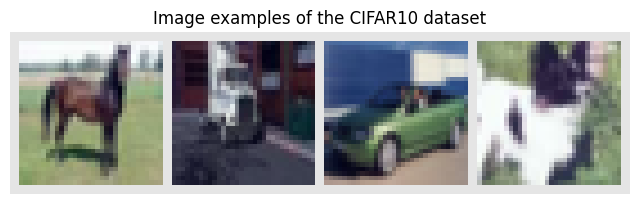

In [6]:
# Visualize some examples
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [7]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape

    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C).transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

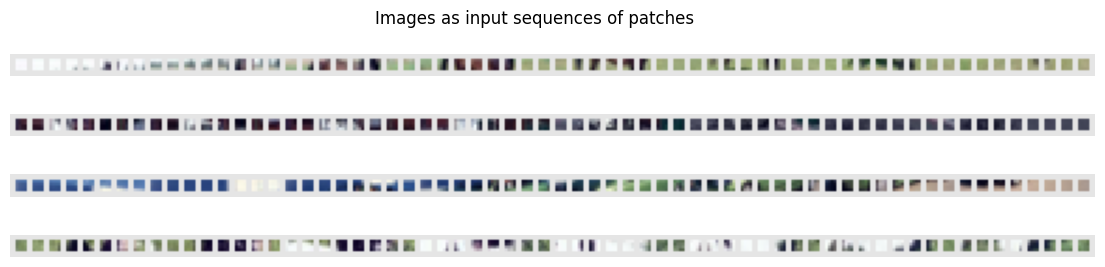

In [8]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [9]:
def rotary_embedding(x, max_seq_len, dim):
    """Apply RoPE to input tensor x."""
    # Ensure max_seq_len is a concrete value, not symbolic
    positions = jnp.arange(max_seq_len, dtype=jnp.float32)
    
    # Ensure freqs is calculated with concrete values for dim
    freqs = 1.0 / (10000 ** (jnp.arange(0, dim, 2, dtype=jnp.float32) / dim))
    
    # Angle calculation with fixed values
    angles = positions[:, None] * freqs[None, :]
    
    sin, cos = jnp.sin(angles), jnp.cos(angles)
    
    # Apply rotary embeddings to the input tensor x
    x1, x2 = x[..., ::2], x[..., 1::2]
    x_rotated = jnp.concatenate([x1 * cos - x2 * sin, x1 * sin + x2 * cos], axis=-1)
    
    return x_rotated

# Scaled Dot-Product Attention

@jax.jit
def scaled_dot_product(q, k, v, mask=None):
    """Computes the scaled dot-product attention."""
    # q -> [B, n_h, L, d_h + d_h^R] 
    # k -> [B, n_h, L, d_h + d_h^R] 
    scale = jnp.sqrt(q.shape[-1])  # Scaling factor for attention scores  d_h + d_h_r
    scores = jnp.einsum("bhqd,bhkd->bhqk", q, k) / scale  # Efficient batch matmul
    
    if mask is not None:
        scores += mask  # Apply mask in-place

    attention = nn.softmax(scores, axis=-1)  # Compute attention weights
    values = jnp.einsum("bhqk,bhkd->bhqd", attention, v)  # Apply attention to values

    return values, attention

# Helper function to support different mask shapes.
# Output shape supports (B, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
@jax.jit
def expand_mask(mask):
    """Expands a mask tensor to shape (B, num_heads, L, L)."""
    ndim = mask.ndim
    assert ndim >= 2, "Mask must be at least 2D (L x L)"

    # Efficient broadcasting using jnp.reshape and jnp.expand_dims
    if ndim == 2:  # (L, L) → (1, 1, L, L)
        return mask[None, None, :, :]
    elif ndim == 3:  # (B, L, L) → (B, 1, L, L)
        return mask[:, None, :, :]
    
    return mask  # If already (B, num_heads, L, L), return as is


class MultiHeadLatentAttentionRope(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension for KV
    d_c_: int  # Latent compression dimension for Queries
    d_h_R: int  # Rotated dimension for RoPE

    def setup(self):
        # self.d_h = self.d_model // self.n_h  # Head dimension
        self.input_h = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        # Combined projection for KV down-projection
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Combined projection for up-projecting KV
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Combined down-projection for Queries
        self.q_proj = nn.Dense(self.d_c_ + self.d_h_R * self.n_h, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Up-projection for Queries
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Rotated projection for keys (shared)
        self.kr_proj = nn.Dense(self.d_h_R , kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        self.rmsNormV_c = nn.RMSNorm()
        self.rmsNormK_c = nn.RMSNorm()
        self.rmsNormQ_c = nn.RMSNorm()


    def __call__(self, x, mask=None):
        B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

        if D != self.d_model:
            x = self.input_h(x)

        if mask is not None:
            mask = expand_mask(mask)

        # Down-project and up-project KV (fused ops)
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each


        # Down-project queries (fused with rotated part)
        c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
        q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]


        # Up-project compressed queries
        q_c = self.uq_proj(q_c)  # [B, L, d_model]

        # Apply RoPE (optimized via vmap)
        q_r = rotary_embedding(q_r, L, self.d_h_R * self.n_h)  # [batch_size, seq_len, d_h_R]
        k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [batch_size, seq_len, d_h_R]

        k_r = jnp.expand_dims(k_r, axis=2) # Shape: [batch_size, seq_len, 1, d_h_R]
        # Broadcast to the desired shape [batch_size, seq_len, num_heads, d_h_R]
       

        k_r = rearrange(jnp.broadcast_to(k_r, (k_r.shape[0], k_r.shape[1], self.n_h, k_r.shape[3])), "b l h d -> b h l d", h=self.n_h, l = L)
      


        v = self.rmsNormV_c(v)
        k = self.rmsNormK_c(k)
        q_c = self.rmsNormQ_c(q_c)

        
        # Reshape heads using einops (faster)
        q_c, k, v, q_r = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v, q_r])

        # Concatenate query and key rotated parts
        q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
        k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

        # Compute attention (efficient)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and project output
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention



class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension
    d_c_: int #Latent caompression dimension fro Q

    def setup(self):
        #self.d_h = self.d_model // self.n_h  # Head dimension

        #RmsNorm after latent variable 
        self.rmsNormV = nn.RMSNorm()
        self.rmsNormK = nn.RMSNorm()
        self.rmsNormQ = nn.RMSNorm()


       # Fused projection layers for efficiency
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.q_proj = nn.Dense(self.d_c_, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Up-projection for keys, values, and queries
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros) 

    def __call__(self, x, mask=None):
        # B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.uq_proj(self.q_proj(x))  # [B, L, d_model]

        # Reshape using einops for efficiency
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        q = self.rmsNormQ(q)
        k = self.rmsNormK(k)
        v = self.rmsNormV(v)
        # Compute attention (optimized version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention
    

class TransformerBlock(nn.Module):
    """A Transformer block with RMS Norm and residual connections."""
    d_model: int  # Dimension of the model (hidden size)
    n_h: int  # Number of attention heads
    dim_feedforward: int    # Dimension of the feed-forward network
    dropout_rate: float = 0.1  # Dropout rate
    d_c : int = 64 # Latent dimension (d_c)
    d_c_: int = 64 # Latent dimension (d_c)
    d_h_R: int = 32  # Rotated dimension (d_h^R)
    position: bool = False


    def setup(self):
        # Attention layer
        if self.position:
            self.self_attn = MultiHeadLatentAttentionRope(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_,
                d_h_R = self.d_h_R)
        else:
            self.self_attn = MultiHeadLatentAttention(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_)
            

        # Feed-Forward Network
        self.ffn = [
            nn.Dense(features=self.dim_feedforward,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.gelu,
            nn.Dropout(self.dropout_rate),
            nn.Dense(features=self.d_model,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.Dropout(self.dropout_rate)
        ]
            
         
        # Layers to apply in between the main layers
        # self.rmsNorm1 = nn.RMSNorm()
        self.rmsNorm2 = nn.RMSNorm()
        self.dropout = nn.Dropout(self.dropout_rate)


    
    def __call__(self, x: jnp.ndarray, mask: Optional[jnp.ndarray] = None, train: bool = False) -> jnp.ndarray:
        """
        Args:
            x: Input tensor of shape (batch, length, d_model)
            mask: Attention mask of shape (batch, heads, length, length) or None
            train: Whether in training mode (for dropout)
        Returns:
            Output tensor of shape (batch, length, d_model)
        """
        # First RMS Norm + Residual Connection
        residual = x
        # x = self.rmsNorm1(x)
        x, _= self.self_attn(x, mask=mask)
        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        # Second RMS Norm + Residual Connection
        
        x = self.rmsNorm2(x)
        x = self.dropout(x, deterministic=not train)

        residual = x
        
        for layer in self.ffn:
            x = layer(x) if not isinstance(layer, nn.Dropout) else layer(x, deterministic=not train)

        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        return x
    


class VisionTransformer(nn.Module):
    embed_dim : int     # Dimensionality of input and attention feature vectors
    hidden_dim : int    # Dimensionality of hidden layer in feed-forward network
    num_heads : int     # Number of heads to use in the Multi-Head Attention block
    num_channels : int  # Number of channels of the input (3 for RGB)
    num_layers : int    # Number of layers to use in the Transformer
    num_classes : int   # Number of classes to predict
    patch_size : int    # Number of pixels that the patches have per dimension
    num_patches : int   # Maximum number of patches an image can have
    dropout_prob : float = 0.0  # Amount of dropout to apply in the feed-forward network
    position: bool = True
    d_c: int = 64 # latent space KV
    d_c_: int = 64 #latent space Q
    d_h_R: int = 64 # Latent space Rptary position per head

    def setup(self):
        # Layers/Networks
        self.input_layer = nn.Dense(self.embed_dim)
        self.transformer = [TransformerBlock(d_model=self.embed_dim,
                                           dim_feedforward = self.hidden_dim,
                                           n_h = self.num_heads,
                                           dropout_rate = self.dropout_prob,
                                           d_c=self.d_c,
                                           d_c_=self.d_c_,
                                           d_h_R=self.d_h_R,
                                           position=self.position
                                           ) for _ in range(self.num_layers)]
        self.mlp_head = nn.Sequential([
            nn.LayerNorm(),
            nn.Dense(self.num_classes)
        ])
        self.dropout = nn.Dropout(self.dropout_prob)

        # Parameters/Embeddings
        self.cls_token = self.param('cls_token',
                                    nn.initializers.normal(stddev=1.0),
                                    (1, 1, self.embed_dim))
        


    def __call__(self, x:jnp.ndarray, train:bool=True):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, axis=0)
        x = jnp.concatenate([cls_token, x], axis=1)
    

        # Apply Transforrmer
        x = self.dropout(x, deterministic=not train)
        for attn_block in self.transformer:
            x = attn_block(x, train=train)

        # Perform classification prediction
        cls = x[:,0]
        out = self.mlp_head(cls)
        return out
    
    def get_attention_maps(self, x:jnp.ndarray, mask:Optional[jnp.ndarray] = None, train:bool=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        # Apply input dropout and linear transformation
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        attention_maps = []
        for attn_block in self.transformer:
            _, attn_maps = attn_block.self_attn(x, mask=mask)
            x = attn_block(x, mask=mask, train=train)

        return attention_maps



In [10]:
## Test AttentionBlock implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))
# Create attention block
attnblock = TransformerBlock(d_model=128, dim_feedforward=512, n_h=4, dropout_rate=0.1)
# Initialize parameters of attention block with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = attnblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, mask=None, train= True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = attnblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del attnblock, params

Out (3, 16, 128)


In [11]:
## Test VisionTransformer implementation
# Example features as input
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (5, 32, 32, 3))
# Create vision transformer
visntrans = VisionTransformer(embed_dim=128,
                              hidden_dim=512,
                              num_heads=4,
                              num_channels=3,
                              num_layers=6,
                              num_classes=10,
                              patch_size=4,
                              num_patches=64,
                              dropout_prob=0.1)
# Initialize parameters of the Vision Transformer with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = visntrans.init({'params': init_rng, 'dropout': dropout_init_rng}, x, True)['params']
# Apply encoder block with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
out = visntrans.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)

del visntrans, params

Out (5, 10)


In [12]:
class TrainerModule:

    def __init__(self, exmp_imgs, lr=1e-3, weight_decay=0.01, seed=42, **model_hparams):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            exmp_imgs - Example imgs, used as input to initialize the model
            lr - Learning rate of the optimizer to use
            weight_decay - Weight decay to use in the optimizer
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.seed = seed
        self.rng = jax.random.PRNGKey(self.seed)
        # Create empty model. Note: no parameters yet
        self.model = VisionTransformer(**model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, 'ViT/')
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, rng, batch, train):
            imgs, labels = batch
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params},
                                      imgs,
                                      train=train,
                                      rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        # Training function
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            (loss, (acc, rng)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        # Eval function
        def eval_step(state, rng, batch):
            # Return the accuracy for a single batch
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return rng, acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        self.rng, init_rng, dropout_init_rng = random.split(self.rng, 3)
        self.init_params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng},
                                           exmp_imgs,
                                           train=True)['params']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.lr,
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),  # Clip gradients at norm 1
            optax.adamw(lr_schedule, weight_decay=self.weight_decay)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, acc = self.train_step(self.state, self.rng, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            self.rng, acc = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target=self.state.params,
                                    step=step,
                                    overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'), target=None)
        self.state = train_state.TrainState.create(
                                       apply_fn=self.model.apply,
                                       params=params,
                                       tx=self.state.tx if self.state else optax.adamw(self.lr)  # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'ViT.ckpt'))

In [13]:
def train_model(*args, num_epochs=2, **kwargs):
  
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
       
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}


In [14]:
d_model=256
hidden_dim = d_model * 2
n_h = 8
d_h = d_model//n_h #(full per-head dimension),
d_c = d_h //2 #(key-value compression dimension)
d_c_ =  d_h //4   # (query compression dimension)
dhR = d_h //4   #decoupled RoPE dimension
num_layers = 4


model, results = train_model(exmp_imgs=next(iter(train_loader))[0],
                             embed_dim=d_model,
                             hidden_dim=hidden_dim,
                             num_heads=n_h,
                             num_layers=num_layers,
                             patch_size=4,
                             num_channels=3,
                             num_patches=64,
                             num_classes=10,
                             dropout_prob=0.2,
                             d_c = d_c,
                             d_c_= d_c_,
                             d_h_R = dhR,
                             position= True,
                             num_epochs=2,  # Example epoch value
                             lr=3e-4)


  0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

Training:   0%|          | 0/703 [00:00<?, ?it/s]

c:\Users\Isabelita\AppData\Local\Programs\Python\Python312\Lib\site-packages\orbax\checkpoint\_src\serialization\type_handlers.py:1251: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [15]:
print("ViT results", results)

ViT results {'val': 0.4453999996185303, 'test': 0.44519999623298645}


In [17]:
x = next(iter(train_loader))[0]

model_test = model.model.bind({'params': model.state.params})

attention_maps = model_test.get_attention_maps(x= x,  train= False )

print(attention_maps)

[]


In [18]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir D:/Malky/research/saved_models/VisionTransformer/tensorboards/



Reusing TensorBoard on port 6006 (pid 14652), started 1 day, 0:12:28 ago. (Use '!kill 14652' to kill it.)